In [ ]:
# to do May 5
# - subtract the measurement and model data.
#   need to bin the measurements to the vertical depth classes of the model
#   look at using technique here https://stackoverflow.com/questions/45273731/binning-column-with-python-pandas
#   or here https://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy
#   trouble is how do I keep the other columns?? Am I binning before the pivot? 

In [ ]:
# load netcdf files from ORAS5 (one per month)
# load netcdf files from observational data (one)

# measurement / observation data: 

# 1/ Older IOS Moored Acoustic Dopller Current Profiler (ADCP) Profile Data 
# https://catalogue.cioospacific.ca/dataset/bodc-meds-cf-v52_ios_adcp_moorings
# https://data.cioospacific.ca/erddap/tabledap/IOS_ADCP_Moorings.html
# 1979 - 2019,  48.1 <= Lat >= 48.7 ,  -125.3 <= Lon >= -124.1  (Juan de Fuca)
# Does not include salinity
# IOS_CUR_Moorings_1979to2019.nc

# 2/ IOS CTD Profiles
# https://data.cioospacific.ca/erddap/tabledap/IOS_CTD_Profiles.html
# https://catalogue.cioospacific.ca/dataset/ios_ctd_profiles
# available back to 1965
# extracted: 1975 - present, 48.1 <= Lat >= 48.7 ,  -125.3 <= Lon >= -124.1  (Juan de Fuca entrance)
#

## TOC: <a class="anchor" id="top"></a>
* [1. IOS DATA](#section-1)
    * [1a. Moored Acoustic Doppler Current Profiler (ADCP)](#section-1a)
    * [1b. IOS CTD Profile](#section-1b) 
    * [1c. Combine IOS ADCP & CTD Data](#section-1c) 
* [2. ORAS5 Data](#section-2) 
* [3. CIOPS Data](#section-3) 

## 1/ IOS DATA <a class="anchor" id="section-1"></a>
### 1a/ Moored Acoustic Doppler Current Profiler (ADCP) <a class="anchor" id="section-1a"></a>

[BACK TO TOP](#top)

<IPython.core.display.Javascript object>


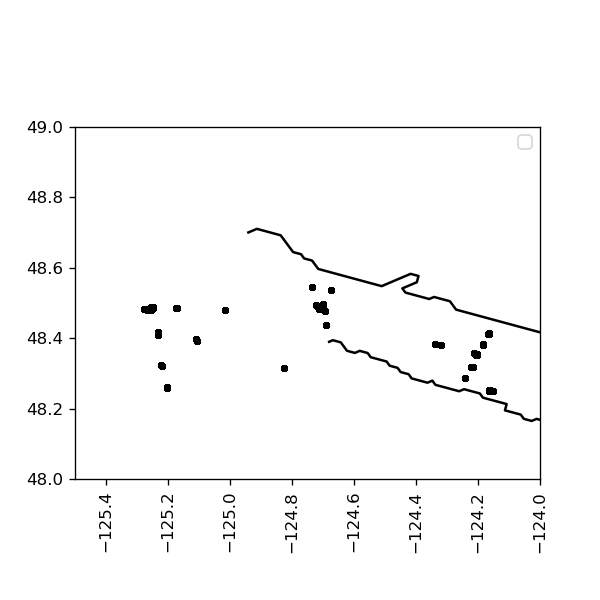

c:\users\greig\documents\github\salishseacast\tools\salishseatools\salishsea_tools\viz_tools.py:125: UserWarning: No contour levels were found within the data range.
  [isobath], colors=color, zorder=zorder)
No handles with labels found to put in legend.


(array([-125.6, -125.4, -125.2, -125. , -124.8, -124.6, -124.4, -124.2,
        -124. ]), <a list of 9 Text xticklabel objects>)

In [2]:
####################### IOS DATA ADCP #########################
# aggregate by year and month
# display as pseudocolor contour plot (x = time, y = depth, color = value)
# alternatively try contour map
%matplotlib notebook
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

IOS_file = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//" + \
"29. Water Properties//IOS Moored Current Meter//IOS_CUR_Moorings_1979to2019.nc"

# load IOS_CUR_Moorings Juan de Fuca
def load_IOS_CUR(f):
    with nc.Dataset(f) as ncid:
                
        latt = ncid.variables["latitude"][:].filled()
        lont = ncid.variables["longitude"][:].filled()
        time_raw = ncid.variables["time"][:].filled()
        depth = ncid.variables["depth"][:].filled()
        inst_depth = ncid.variables["instrument_depth"][:].filled()
        temper1 = ncid.variables["TEMPPR01"][:].filled()        

    return latt, lont, time_raw, depth, inst_depth, temper1

latt, lont, time_raw, depth, inst_depth, temp = load_IOS_CUR(IOS_file)
time_counter_units = "seconds since 1970-01-01 00:00:00"
time_counter_calendar = "gregorian"
time_py = nc.num2date(time_raw, time_counter_units, time_counter_calendar)

df_IOS = pd.DataFrame({'time_py':time_py, 'temp':temp, 
                       'inst_depth':inst_depth, 'lat':latt,
                      'lon':lont})
df_IOS['time_py'] = pd.to_datetime(df_IOS['time_py'])
df_IOS['year'] = df_IOS['time_py'].dt.year
df_IOS['month'] = df_IOS['time_py'].dt.month

#Visuals - map
# viz_tools expects bathy when from local server to have following variables: 
#    lon_name = 'nav_lon', lat_name = 'nav_lat', bathy_name = 'Bathymetry'
from salishsea_tools import evaltools as et, viz_tools, geo_tools

df_coords = pd.DataFrame({'latt':latt, 'lont':lont})
df_uniquecoords = pd.unique(df_coords[['latt', 'lont']].values.ravel('K'))

fig, ax = plt.subplots(figsize = (5,5))
viz_tools.set_aspect(ax, coords = 'map')

with nc.Dataset('..//data//bathymetry//bathy_salishsea_1500m_20210406.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(lont, latt, '.k')
ax.set_ylim(48, 49)
ax.legend()
ax.set_xlim(-125.5, -124)
plt.xticks(rotation=90)

<IPython.core.display.Javascript object>


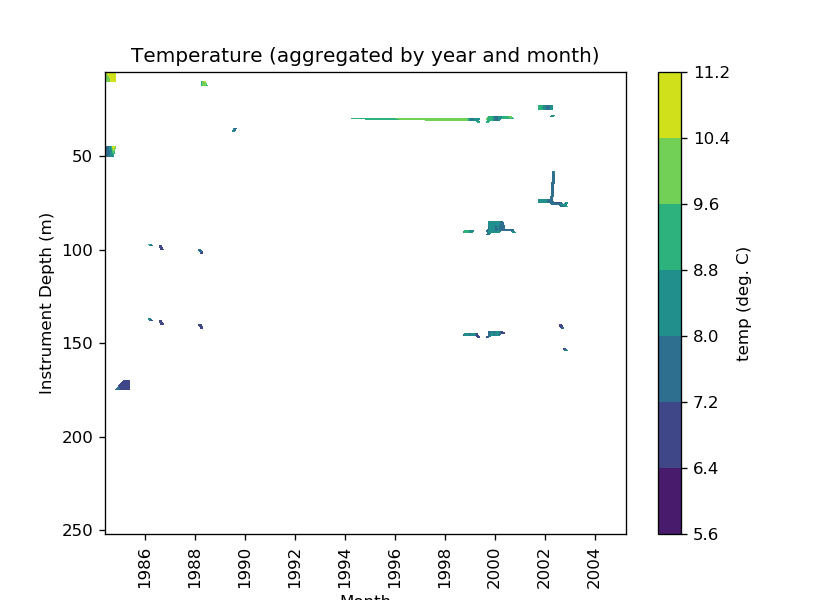

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [3]:
# group measurements by year and month
df2_IOS_ADCP = df_IOS.groupby(['year','month','inst_depth']).agg('mean').reset_index()
df2_IOS_ADCP['yearmonth']=(df2_IOS_ADCP['year'].astype(int)).astype(str) + "/" + (df2_IOS_ADCP['month'].astype(int)).astype(str)
df2_IOS_ADCP['yearmonth']=pd.to_datetime(df2_IOS_ADCP['yearmonth'], format='%Y/%m')

# contour plots require matrix operations to prep the data

val_pivot_df_IOS_Cur = df2_IOS_ADCP.pivot(index='inst_depth', columns='yearmonth', values='temp')
dates = val_pivot_df_IOS_Cur.columns.values
depths = val_pivot_df_IOS_Cur.index.values
x, y = np.meshgrid(dates,depths)
data_values = val_pivot_df_IOS_Cur.values
masked_data = np.ma.masked_invalid(data_values)
fig, ax = plt.subplots(figsize = (7,5))
ax.set_title('Temperature (aggregated by year and month)')
ax.set_xlabel('Month')
ax.set_ylabel('Instrument Depth (m)')
CS = ax.contourf(x, y, masked_data)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('temp (deg. C)')
plt.xticks(rotation=90)
plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>


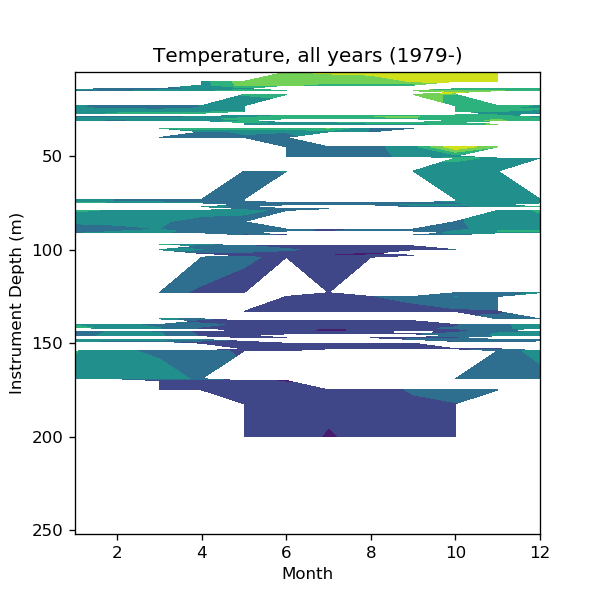

In [4]:
# group measurements by month (all years together)
df3 = df2_IOS_ADCP.groupby(['month','inst_depth']).agg('mean').reset_index()
val_pivot_df3 = df3.pivot(index='inst_depth', columns='month', values='temp')
dates2 = val_pivot_df3.columns.values
depths2 = val_pivot_df3.index.values
x2, y2 = np.meshgrid(dates2,depths2)
data_values2 = val_pivot_df3.values
masked_data2 = np.ma.masked_invalid(data_values2)
fig2, ax2 = plt.subplots(figsize = (5,5))

ax2.set_title('Temperature, all years (1979-)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Instrument Depth (m)')
plt.gca().invert_yaxis()
CS = ax2.contourf(x2, y2, masked_data2)

### 1b/ IOS CTD Profile
<a class="anchor" id="section-1b"></a>

[BACK TO TOP](#top)

In [5]:
####################### IOS DATA CTD PROFILES #########################
from sqlalchemy import create_engine, case, MetaData

IOS_CTD_file = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//" + \
"29. Water Properties//IOS CTD Profiles//IOS_CTD_Profiles_JDFEntrance_1975topresent.nc"

# load IOS CTD Profiles data
def load_IOS_CTD(f):
    with nc.Dataset(f) as ncid:
        # there are no station IDs
        #print(ncid.variables)
        latt = ncid.variables["latitude"][:].filled()
        lont = ncid.variables["longitude"][:].filled()
        time_raw = ncid.variables["time"][:].filled()
        depth = ncid.variables["depth"][:].filled()
        temper1 = ncid.variables["sea_water_temperature"][:].filled()
        temper2 = ncid.variables["TEMPS901"][:].filled()
        temper3 = ncid.variables["TEMPS902"][:].filled()
        temper4 = ncid.variables["TEMPS601"][:].filled()
        temper5 = ncid.variables["TEMPS602"][:].filled()
        temper6 = ncid.variables["TEMPST01"][:].filled()
        salin1_PSS_78 = ncid.variables["sea_water_practical_salinity"][:].filled()
        salin2_PSS_78 = ncid.variables["PSALST01"][:].filled()
        salin3_PSS_78 = ncid.variables["PSALST02"][:].filled()        
        salin4_PPT = ncid.variables["SSALST01"][:].filled()
        
        # combine fields that represent the same thing but have different names:
        temper = np.zeros(shape=(len(temper1)))
        i = 0
        for t in temper1:
            if t!= None:
                temper[i] = t
            elif temper2[i]!=None:
                temper[i] = temper2
            elif temper3[i]!=None:
                temper[i] = temper3
            elif temper4[i]!=None:
                temper[i] = temper4
            elif temper5[i]!=None:
                temper[i] = temper5
            elif temper6[i]!=None:
                temper[i] = temper6
            else:
                temper[i] = temper1
            i += 1
            
        salin = np.zeros(shape=(len(salin1_PSS_78)))
        i = 0
        
        # I'm assuming PSS_78 units and PPT are same...?
        for s in salin1_PSS_78:
            if s!= None:
                salin[i] = s
            elif salin2_PSS_78[i]!=None:
                salin[i] = salin2_PSS_78
            elif salin3_PSS_78[i]!=None:
                salin[i] = salin3_PSS_78
            elif salin4_PPT[i]!=None:
                salin[i] = salin4_PPT
            else:
                salin[i] = s
            i += 1
        
        return latt, lont, time_raw, depth, temper, salin

latt, lont, time_raw, depth, temper, salin = load_IOS_CTD(IOS_CTD_file)

time_counter_units = "seconds since 1970-01-01 00:00:00"
time_counter_calendar = "gregorian"
time_py = nc.num2date(time_raw, time_counter_units, time_counter_calendar)

# temperature
df_IOS_CTD_temp = pd.DataFrame({'time_py':time_py, 'temper':temper,
                                'depth':depth, 'lat':latt, 'lon':lont})
df_IOS_CTD_temp['time_py'] = pd.to_datetime(df_IOS_CTD_temp['time_py'])
df_IOS_CTD_temp['year'] = df_IOS_CTD_temp['time_py'].dt.year
df_IOS_CTD_temp['month'] = df_IOS_CTD_temp['time_py'].dt.month

# salinity
df_IOS_CTD_salin = pd.DataFrame({'time_py':time_py, 'salin':salin,
                                'depth':depth, 'lat':latt, 'lon':lont})
df_IOS_CTD_salin['time_py'] = pd.to_datetime(df_IOS_CTD_temp['time_py'])
df_IOS_CTD_salin['year'] = df_IOS_CTD_salin['time_py'].dt.year
df_IOS_CTD_salin['month'] = df_IOS_CTD_salin['time_py'].dt.month

# save a copy for later
df_IOS_CTD_temp_saved = df_IOS_CTD_temp
df_IOS_CTD_temp.drop(['lat','lon'], axis=1)
df_IOS_CTD_salin_saved = df_IOS_CTD_salin
df_IOS_CTD_salin.drop(['lat','lon'], axis=1)

# remove null values
df_IOS_CTD_temp = df_IOS_CTD_temp[df_IOS_CTD_temp['temper'].notnull()]
df_IOS_CTD_salin = df_IOS_CTD_salin[df_IOS_CTD_salin['salin'].notnull()]

# group by year / month
# depths are too precise - group by metre
df_IOS_CTD_temp['depth_m'] = np.round(df_IOS_CTD_temp['depth'],0)
df_IOS_CTD_temp = df_IOS_CTD_temp.groupby(['year','month','depth_m']).agg('mean').reset_index()
df_IOS_CTD_salin['depth_m'] = np.round(df_IOS_CTD_salin['depth'],0)
df_IOS_CTD_salin = df_IOS_CTD_salin.groupby(['year','month','depth_m']).agg('mean').reset_index()

# prep quantitative x axis of dates
df_IOS_CTD_temp['yearmonth']=(df_IOS_CTD_temp['year'].astype(int)).astype(str) + "/" + (df_IOS_CTD_temp['month'].astype(int)).astype(str)
df_IOS_CTD_temp['yearmonth']=pd.to_datetime(df_IOS_CTD_temp['yearmonth'], format='%Y/%m')
df_IOS_CTD_salin['yearmonth']=(df_IOS_CTD_salin['year'].astype(int)).astype(str) + "/" + (df_IOS_CTD_salin['month'].astype(int)).astype(str)
df_IOS_CTD_salin['yearmonth']=pd.to_datetime(df_IOS_CTD_salin['yearmonth'], format='%Y/%m')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>


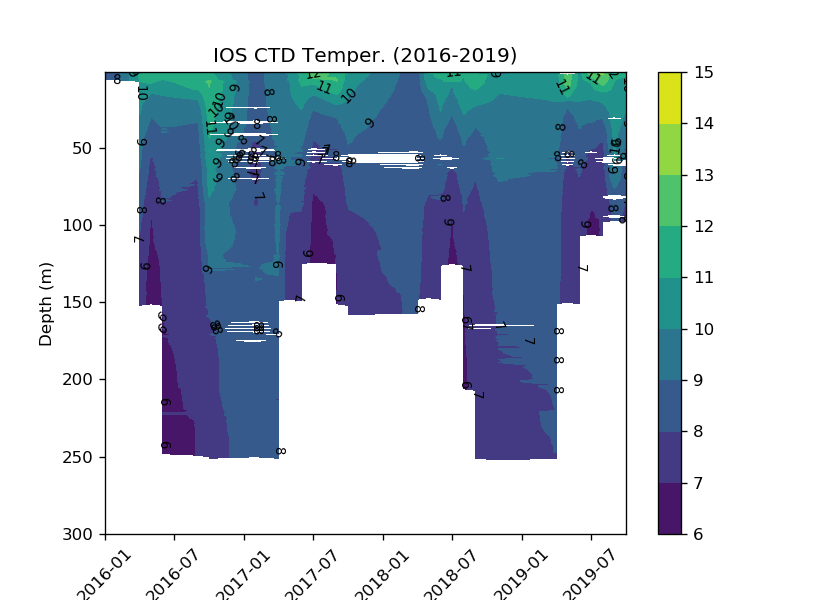

(array([735964., 736146., 736330., 736511., 736695., 736876., 737060.,
        737241.]), <a list of 8 Text xticklabel objects>)

In [8]:
# optional filter by year
year_min = 2016
year_max = 2019

# mouth of JDF west
lon_min = -125.3
# lon_max = -124.8
# lat_min = 48.33
# lat_max = 48.7

# mouth JDF east 
# lon_min = -124.8
lon_max = -124
lat_min = 48.2
lat_max = 48.7

df_IOS_CTD_temp = df_IOS_CTD_temp[(df_IOS_CTD_temp['year'] >= year_min) &
                                 (df_IOS_CTD_temp['year'] <= year_max) & 
                                 (df_IOS_CTD_temp['lat'] >= lat_min) & 
                                 (df_IOS_CTD_temp['lat'] <= lat_max)& 
                                 (df_IOS_CTD_temp['lon'] >= lon_min)& 
                                 (df_IOS_CTD_temp['lon'] <= lon_max)]
df_IOS_CTD_salin = df_IOS_CTD_salin[(df_IOS_CTD_salin['year'] >= year_min) &
                                 (df_IOS_CTD_salin['year'] <= year_max) & 
                                 (df_IOS_CTD_salin['lat'] >= lat_min) & 
                                 (df_IOS_CTD_salin['lat'] <= lat_max)& 
                                 (df_IOS_CTD_salin['lon'] >= lon_min)& 
                                 (df_IOS_CTD_salin['lon'] <= lon_max)]
ylim = 300
levels = np.linspace(6.0, 15, 10)
fmt = "%.0f"
val_pivot_df = df_IOS_CTD_temp.pivot(index='depth_m', columns='yearmonth', values='temper')
dates = val_pivot_df.columns.values
depths = val_pivot_df.index.values
x, y = np.meshgrid(dates,depths)
data_values = val_pivot_df.values
masked_data = np.ma.masked_invalid(data_values)
fig, ax = plt.subplots(figsize = (7,5))
ax.set_title("IOS CTD Temper. (" + str(year_min) + "-" + str(year_max) + ")")
ax.set_xlabel('Month')
ax.set_ylabel('Depth (m)')
ax.set_ylim(ylim)
CS = ax.contourf(x, y, data_values, levels=levels)
ax.clabel(CS, inline=0, fontsize=8, fmt=fmt, colors="k")
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('temp (deg. C)')
plt.xticks(rotation=45)
#plt.gca().invert_yaxis()


<IPython.core.display.Javascript object>


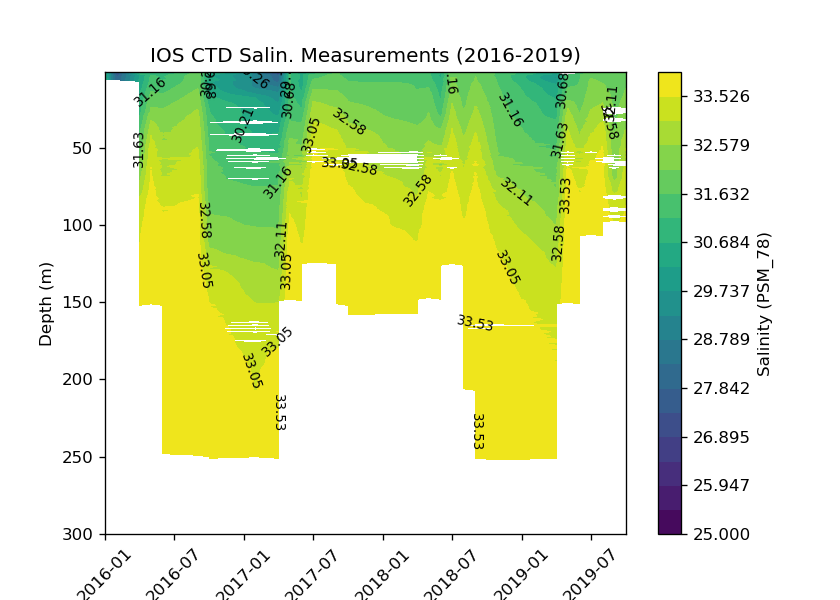

In [10]:
plot_title = "IOS CTD Salin. Measurements (" + str(year_min) + "-" + str(year_max) + ")"
x_label = "Month"
y_label = "Depth (m)"
y_label_bar = 'Salinity (PSM_78)'
ylim = 300
levels = np.linspace(25, 34, 20)
fmt = "%.2f"
val_pivot_df = df_IOS_CTD_salin.pivot(index='depth_m', columns='yearmonth', values='salin')
dates = val_pivot_df.columns.values
depths = val_pivot_df.index.values
x, y = np.meshgrid(dates,depths)
data_values = val_pivot_df.values
masked_data = np.ma.masked_invalid(data_values)
fig, ax = plt.subplots(figsize = (7,5))
ax.set_title(plot_title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_ylim(ylim)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel(y_label_bar)
plt.xticks(rotation=45)
#plt.gca().invert_yaxis()
CS = ax.contourf(x, y, data_values, levels = levels)
ax.clabel(CS, inline=0, fontsize=8, fmt=fmt, colors="k")

data_values_IOS_salin = data_values

In [11]:
df_IOS_CTD_salin["salin"].describe()

count    5139.000000
mean       33.096853
std         1.007192
min        26.809150
25%        32.488341
50%        33.590743
75%        33.851531
max        33.957001
Name: salin, dtype: float64

<IPython.core.display.Javascript object>


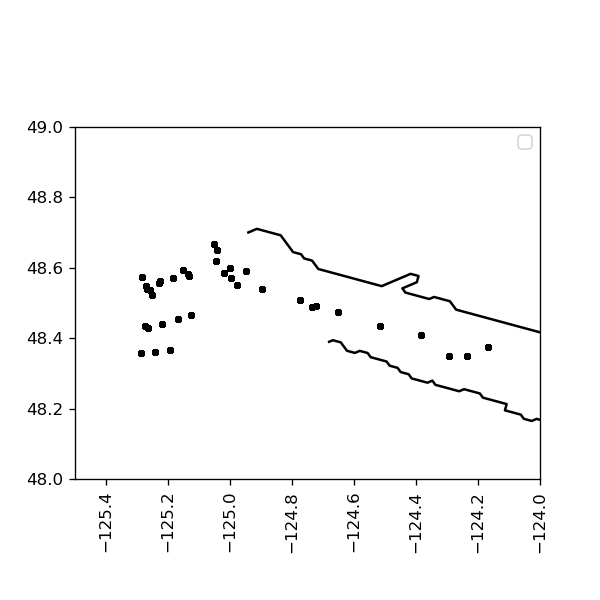

No handles with labels found to put in legend.


(array([-125.6, -125.4, -125.2, -125. , -124.8, -124.6, -124.4, -124.2,
        -124. ]), <a list of 9 Text xticklabel objects>)

In [12]:
# visualize locations
Year = 1979
OneYear_data = df_IOS_CTD_temp_saved[(df_IOS_CTD_temp_saved['year'] == Year)]

df_coords = pd.DataFrame({'lat':OneYear_data['lat'], 'lon':OneYear_data['lon']})

fig, ax = plt.subplots(figsize = (5,5))
viz_tools.set_aspect(ax, coords = 'map')

with nc.Dataset('..//data//bathymetry//bathy_salishsea_1500m_20210406.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(df_coords['lon'], df_coords['lat'], '.k')
ax.set_ylim(48, 49)
ax.legend()
ax.set_xlim(-125.5, -124)
plt.xticks(rotation=90)

## 1c/ Combine IOS ADCP & CTD Data (temperature only)
<a class="anchor" id="section-1c"></a>

[BACK TO TOP](#top)

In [13]:
df_IOS_ADCP = df_IOS
df_IOS_ADCP["depth_m"] = df_IOS_ADCP["inst_depth"]
df_IOS_ADCP["temper"] = df_IOS_ADCP["temp"]
df_IOS_ADCP['yearmonth'] = (df_IOS_ADCP['year'].astype(int)).astype(str) + "/" + (df_IOS_ADCP['month'].astype(int)).astype(str)
df_IOS_ADCP['yearmonth'] = pd.to_datetime(df_IOS_ADCP['yearmonth'], format='%Y/%m')

df_IOS_ADCP_CTD = pd.concat([df_IOS_ADCP, df_IOS_CTD_temp])
df_IOS_ADCP_CTD = df_IOS_ADCP_CTD.drop(['depth','inst_depth','temp'], axis=1)
max(df_IOS_ADCP_CTD['temper'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


<IPython.core.display.Javascript object>


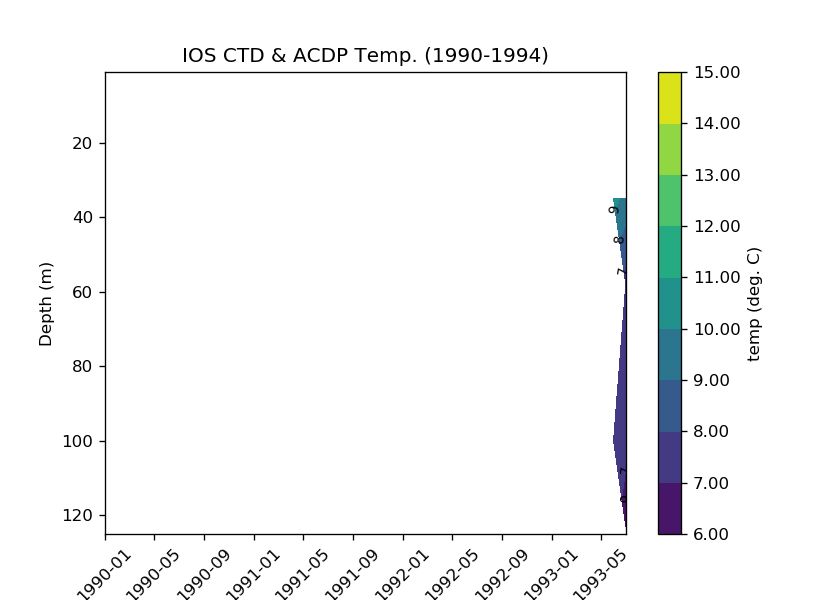

<a list of 5 text.Text objects>

In [20]:
# optional filter by year and lat / lon
year_min = 1990
year_max = 1994

# mouth of JDF west
lon_min = -125.3
#lon_max = -124.8
lat_min = 48.33
#lat_max = 48.7

# mouth JDF east 
# lon_min = -124.8
lon_max = -124
# lat_min = 48.2
lat_max = 48.7

df_IOS_ADCP_CTD_f = df_IOS_ADCP_CTD[(df_IOS_ADCP_CTD['year'] >= year_min) &
                                 (df_IOS_ADCP_CTD['year'] <= year_max) & 
                                 (df_IOS_ADCP_CTD['lat'] >= lat_min) & 
                                 (df_IOS_ADCP_CTD['lat'] <= lat_max)& 
                                 (df_IOS_ADCP_CTD['lon'] >= lon_min)& 
                                 (df_IOS_ADCP_CTD['lon'] <= lon_max)]

df_IOS_ADCP_CTD_g = df_IOS_ADCP_CTD_f.groupby(['year','month','yearmonth','depth_m']).agg('mean').reset_index()
df_IOS_ADCP_CTD_g = df_IOS_ADCP_CTD_g.drop(['lat','lon'], axis=1)
df_IOS_ADCP_CTD_g = df_IOS_ADCP_CTD_g.sort_values(by='yearmonth', ascending=False).reset_index()

val_pivot_df = df_IOS_ADCP_CTD_g.pivot(index='depth_m', columns='yearmonth', values='temper')
depths = val_pivot_df.index.values
dates = val_pivot_df.columns.values

x, y = np.meshgrid(dates,depths)
data_values = val_pivot_df.values
masked_data = np.ma.masked_invalid(data_values)
fig, ax = plt.subplots(figsize = (7,5))
ax.set_title("IOS CTD & ACDP Temp. (" + str(year_min) + "-" + str(year_max) + ")")
ax.set_xlabel('Month')
ax.set_ylabel('Depth (m)')
ax.set_ylim(125)
fmt = "%.2f"
cbar = fig.colorbar(CS,format=fmt)
cbar.ax.set_ylabel('temp (deg. C)')
plt.xticks(rotation=45)
levels = np.linspace(6.0, 15, 10)
#plt.gca().invert_yaxis()

# two options - contour and contourf
#CS = ax.contour(x, y, data_values, levels=levels)
CS = ax.contourf(x, y, data_values, levels=levels)
fmt = "%.0f"
ax.clabel(CS, inline=0, fontsize=8, fmt=fmt, colors="k")

## 2/ ORAS5 Data
<a class="anchor" id="section-2"></a>

[BACK TO TOP](#top)

In [18]:
#print(lont[26,28])
#print(latt[26,28])
#i = 26
#j = 26
#val_pivot_df

<IPython.core.display.Javascript object>


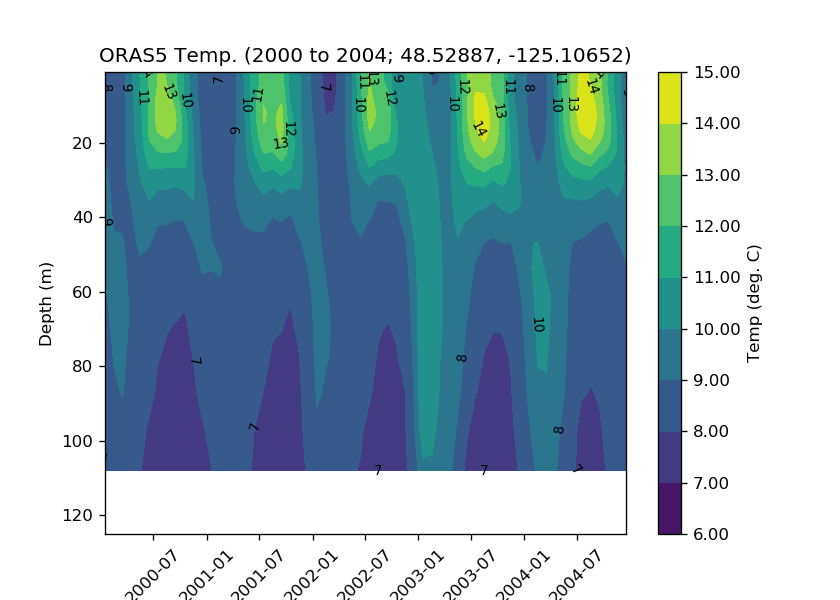

In [22]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt 
import netCDF4 as nc
import pandas as pd

########################### ORAS5 Data ##############################
# extract temp. and salin. for a coordinate from the ORAS5 files. 
# (one file per month)
ORAS5_path = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//29. Water Properties//ECMWF ORAS5//"


# Load ORAS5 monthly .nc
def load_ORAS5_temp(f, i, j):
    with nc.Dataset(f) as ncid:
        
        latt = ncid.variables["nav_lat"][:,:].filled()
        lont = ncid.variables["nav_lon"][:,:].filled()
        time_raw = ncid.variables["time_counter"][:].filled()
        depth = ncid.variables["deptht"][:].filled()
  
        ' temp dimensions: time, depth, lon, lat'
        temp = ncid.variables["votemper"][:,:,i,j].filled()
        
    return latt, lont, time_raw, depth, temp

def load_ORAS5_salin(f, i, j):
    with nc.Dataset(f) as ncid:
        
        latt = ncid.variables["nav_lat"][:,:].filled()
        lont = ncid.variables["nav_lon"][:,:].filled()
        time_raw = ncid.variables["time_counter"][:].filled()
        depth = ncid.variables["deptht"][:].filled()
  
        ' temp dimensions: time, depth, lon, lat'
        salin = ncid.variables["vosaline"][:,:,i,j].filled()
        
    return latt, lont, time_raw, depth, salin

# Find coord to extract ORAS5 data from
# e.g., i = 26, j = 26, lat = 48.52887, -125.10652
#print(lont[26,26])
#print(latt[26,26])
i = 26
j = 26

# stitch together the multiple monthly files
year = start_year
month = 1
time_array = pd.DataFrame(columns=['dates'])

while year <= max_year:
    month = 1
    while month <= 12:
        
        # ORAS5 file format: "votemper_ORAS5_1m_199205_grid_T_02_salishsea.nc"
        if month < 10: 
            month_str = "0" + str(month)
        else:
            month_str = str(month)
        
        time_1 = pd.DataFrame(data = {'dates': [pd.to_datetime(str(year) + "/" + month_str + "/" + str(16))]})
        
        ORAS5_file_full_tem = (ORAS5_path + "votemper_ORAS5_1m_" + str(year) +
                           month_str + "_grid_T_02_salishsea.nc")
        # most of these returned vars are unused right now
        latt_tem, lont_tem, time_raw_tem, depth_tem, temp = load_ORAS5_temp(ORAS5_file_full_tem, i, j)     
        
        ORAS5_file_full_sal = (ORAS5_path + "vosaline_ORAS5_1m_" + str(year) +
                           month_str + "_grid_T_02_salishsea.nc")
        latt_sal, lont_sal, time_raw_sal, depth_sal, salin = load_ORAS5_salin(ORAS5_file_full_sal, i, j)
        
        time_array = time_array.append((time_1))
        
        # FIX INFINITE VALUES OF 9.96921E36f; 
        temp = np.where(temp > 10000, np.NaN, temp)
        salin = np.where(salin > 10000, np.NaN, salin)
        
        # stack the measurement data for each time step into one array
        if (year == start_year) & (month == 1):
            temp_stack = temp
            salin_stack = salin
        else:
            temp_stack = np.vstack((temp_stack, temp))
            salin_stack = np.vstack((salin_stack, salin))
        
        month += 1
    year += 1

def plot_contour_ORAS5(plot_title, cbar_label, x_label, y_label, y_lim, 
                      x, y, masked_data, levels):
    
    fig, ax = plt.subplots(figsize = (7,5))
    ax.set_title(plot_title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    plt.xticks(rotation=45)
    #ax.invert_yaxis()

    CS = ax.contourf(x, y, masked_data, levels=levels)
    fmt = "%.0f"
    ax.clabel(CS, inline=0, fontsize=8, fmt=fmt, colors="k")

    fmt = "%.2f"
    cbar = plt.colorbar(CS,format=fmt)
    cbar.ax.set_ylabel(cbar_label)

    # store indices of latts and lonts
    #latt['index1'] = latt.index
    #lont['index1'] = lont.index

# reshape the stacked array (depth first, time second)
y, x = np.meshgrid(depth_tem, time_array)
masked_data = np.ma.masked_invalid(temp_stack)
    
plot_title = "ORAS5 Temp. (" + str(start_year)  + " to " + str(max_year) + \
"; " + str((latt_sal[i,j])) + ", " + str((lont_sal[i,j])) + ")"

cbar_label = "Temp (deg. C)"
x_label = "Month"
y_label = "Depth (m)"
y_lim = 125
levels = np.linspace(6.0, 15, 10)

plot_contour_ORAS5(plot_title, cbar_label, x_label, y_label, y_lim, x, y, masked_data, levels)
    

In [23]:
np.min(masked_data)

7.2813234

<IPython.core.display.Javascript object>


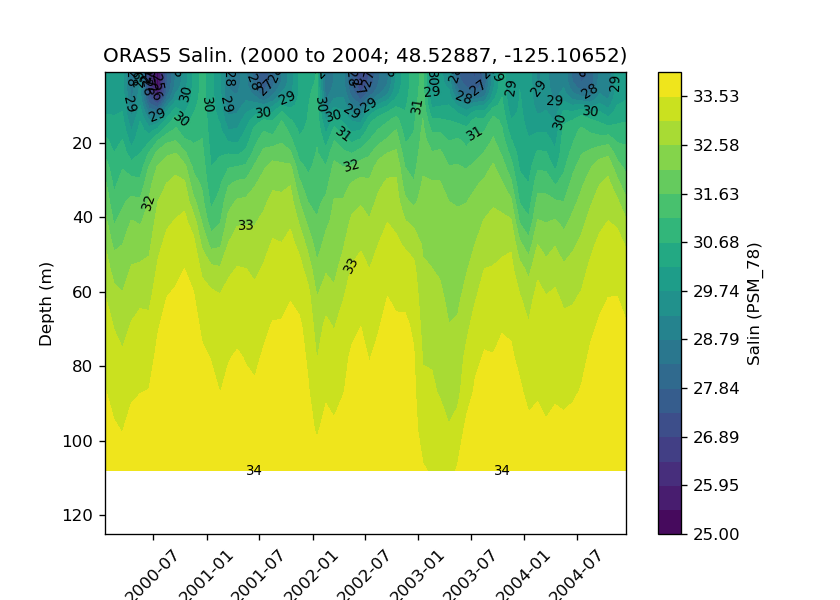

In [24]:
# reshape the stacked array (depth first, time second)
y, x = np.meshgrid(depth_sal, time_array)
masked_data = np.ma.masked_invalid(salin_stack)
    
plot_title = "ORAS5 Salin. (" + str(start_year)  + " to " + str(max_year) + \
"; " + str((latt_sal[i,j])) + ", " + str((lont_sal[i,j])) + ")"

cbar_label = "Salin (PSM_78)"
x_label = "Month"
y_label = "Depth (m)"
y_lim = 125
levels = np.linspace(25, 34, 20)


plot_contour_ORAS5(plot_title, cbar_label, x_label, y_label, y_lim, x, y, masked_data, levels)

salin_stack_ORAS5 = salin_stack

In [25]:
depth_sal#salin_stack_ORAS5.shape

array([5.0576001e-01, 1.5558553e+00, 2.6676817e+00, 3.8562799e+00,
       5.1403613e+00, 6.5430336e+00, 8.0925188e+00, 9.8227501e+00,
       1.1773680e+01, 1.3991038e+01, 1.6525322e+01, 1.9429802e+01,
       2.2757616e+01, 2.6558300e+01, 3.0874561e+01, 3.5740204e+01,
       4.1180023e+01, 4.7211895e+01, 5.3850636e+01, 6.1112839e+01,
       6.9021683e+01, 7.7611160e+01, 8.6929428e+01, 9.7041313e+01,
       1.0803028e+02, 1.2000000e+02, 1.3307582e+02, 1.4740625e+02,
       1.6316446e+02, 1.8054993e+02, 1.9978996e+02, 2.2114117e+02,
       2.4489062e+02, 2.7135638e+02, 3.0088751e+02, 3.3386282e+02,
       3.7068848e+02, 4.1179385e+02, 4.5762561e+02, 5.0863989e+02,
       5.6529230e+02, 6.2802600e+02, 6.9725867e+02, 7.7336829e+02,
       8.5667896e+02, 9.4744788e+02, 1.0458542e+03, 1.1519912e+03,
       1.2658615e+03, 1.3873770e+03, 1.5163636e+03, 1.6525685e+03,
       1.7956708e+03, 1.9452955e+03, 2.1010266e+03, 2.2624216e+03,
       2.4290251e+03, 2.6003804e+03, 2.7760393e+03, 2.9555703e

<IPython.core.display.Javascript object>


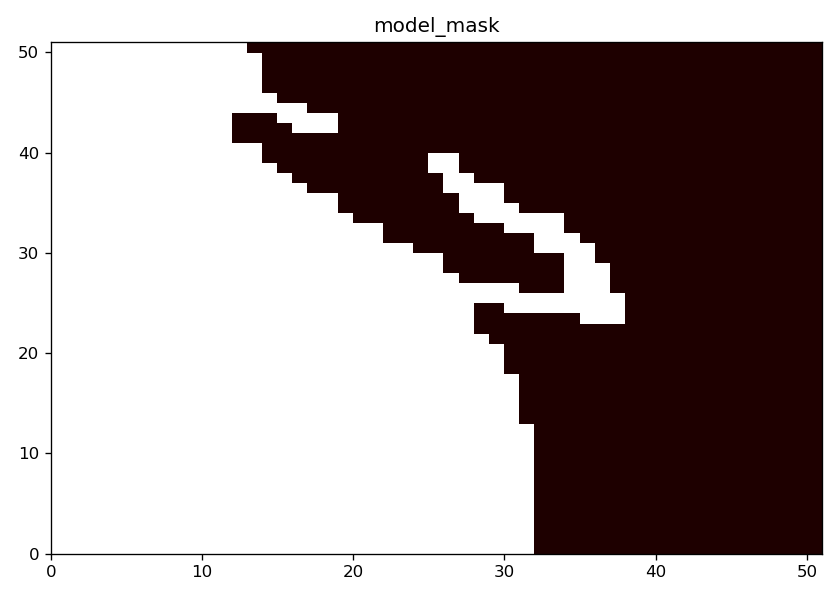

In [29]:
oras5path = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//29. Water Properties//ECMWF ORAS5//"
oras5mask = oras5path + "mesh_mask.nc"
oras5mask_trunc = oras5path + "mesh_mask_trunc.nc"

with nc.Dataset(oras5mask) as ncid:
    tmask = ncid.variables["tmask"][0,0,:, :].filled()
    latt_mask = ncid.variables["nav_lat"][:, :].filled()
    lont_mask = ncid.variables["nav_lon"][:, :].filled()

with nc.Dataset(oras5mask_trunc) as ncid:
    #print(ncid.variables)
    tmask_trunc = ncid.variables["tmask"][0,0,:, :].filled()
    latt_mask_trunc = ncid.variables["nav_lat"][:, :].filled()
    lont_mask_trunc = ncid.variables["nav_lon"][:, :].filled()
    
fig, ax = plt.subplots(figsize = (7,5))
plt.subplot(1,1,1)
plt.pcolormesh(tmask_trunc[:,:], cmap=plt.pink()); plt.title("model_mask")
plt.tight_layout()
#plt.scatter(tmask_trunc[0,:].index,tmask_trunc[:,0], marker='.')
#plt.scatter(lont_mask, latt_mask, marker='.')
# plt.scatter(lont, latt, marker='.')
#plt.xlim([-126.2,-122.1])
#plt.ylim([46.84,52])

(1021, 1442)


<IPython.core.display.Javascript object>


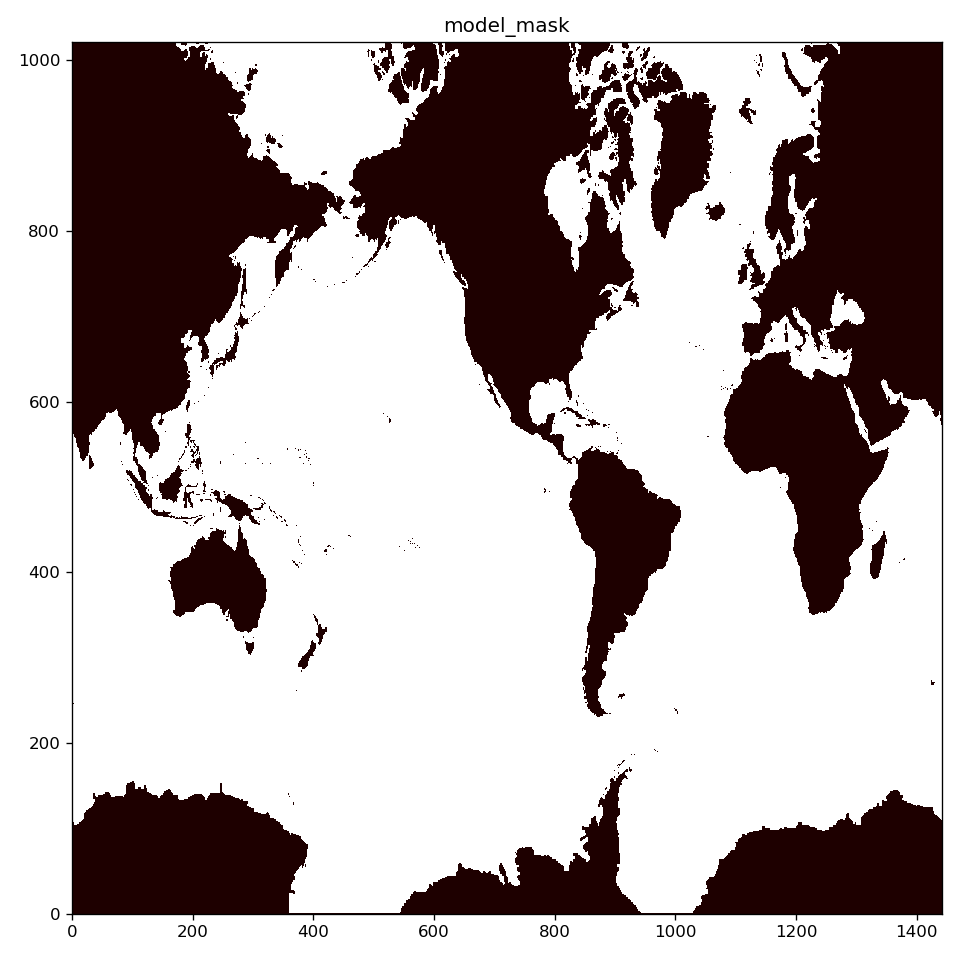

In [32]:

def load_mask(f):
    with nc.Dataset(f) as ncid:
        tmask = ncid.variables["tmask"][0,0,:, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()
        e1t = ncid.variables["e1t"][0,:, :].filled()
        e2t = ncid.variables["e2t"][0,:, :].filled()

    return tmask, latt, lont, e1t, e2t

tmask, latt_mask_, lont_mask, e1t_mask, e2t_mask = load_mask(oras5mask)
print(tmask.shape)
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.pcolormesh(tmask[:,:], cmap=plt.pink()); plt.title("model_mask")
plt.tight_layout()

## 3/ CIOPSw Data
<a class="anchor" id="section-3"></a>

[BACK TO TOP](#top)

In [ ]:
########################### CIOPSw Data ##############################
# extract temp. and salin. for a coordinate from the ORAS5 files. 
# (one file per day)
start_year = 2016
max_year = 2019
start_month = 1
max_month = 12
CIOPSw_path = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//29. Water Properties//CIOPSWest//bdy_ts//"
mesh_mask_file = "C://Users//Greig//Documents//GitHub//NEMO-Salish-Sea-2021//data//mesh mask//mesh_mask_20210406.nc"

#test_file = "ts_N_y2016m04d23.nc"

# Load CIOPS daily temp / salin .nc
def load_CIOPS_ts(CIOPSw_path, year, month, month_str, mesh_mask_file):
    
    day_cnt = numberOfDays(year,month)
    
    # depths defining the vert layers of model
    gdept1d, gdepw1d = load_depths_mesh(mesh_mask_file) #center and edges of lyr
    depths_t = pd.DataFrame(data = {'depths_t': gdept1d})
    depths_t.reset_index(inplace=True)
    depths_t['nemo_vert_layer'] = depths_t['index']
    depths_w = pd.DataFrame(data = {'depths_w': gdepw1d})
    
    time_counter_units = "seconds since 1950-01-01 00:00:00"
    time_counter_calendar = "gregorian"    
    data_df = pd.DataFrame()
    day = 1
    while day <= day_cnt:
        if day < 10: 
            day_str = "0" + str(day)
        else:
            day_str = str(day)
        
        # get CIOPS boundary data for western boundary
        f = CIOPSw_path + "ts_W_y" + str(year) + "m" + month_str + "d" + day_str + ".nc"
        with nc.Dataset(f) as ncid:
            print(ncid.variables)
            time_raw = ncid.variables["time_counter"][:].filled()
  
            # temp dimensions: time, depth, xb, yb'
            temp = ncid.variables["votemper"][:,:,:,:].filled()
            salin = ncid.variables["vosaline"][:,:,:,:].filled()
        
            time_py = np.zeros(time_raw.shape)
            time_py = nc.num2date(time_raw, time_counter_units, time_counter_calendar)
            time_py_df = pd.DataFrame({'time_py':time_py})
            time_py_df['year'] = (time_py_df['time_py'].dt.year).astype(int)
            time_py_df['month'] = (time_py_df['time_py'].dt.month).astype(int)
            time_py_df['day'] = (time_py_df['time_py'].dt.day).astype(int)
            time_py_df['yearmonth']=time_py_df['year'].astype(str) + "/" + time_py_df['month'].astype(str)
            time_py_df['yearmonth']=pd.to_datetime(time_py_df['yearmonth'], format='%Y/%m')
            time_py_df['yearmonthday']=time_py_df['year'].astype(str) + "/" + time_py_df['month'].astype(str) + "/" + time_py_df['day'].astype(str)
            time_py_df['yearmonthday']=pd.to_datetime(time_py_df['yearmonthday'], format='%Y/%m/%d')
        
            # change zeros to nulls
            salin_m= np.ma.array(salin, mask=salin==0)
            s1 = np.mean(salin_m, axis=3) #y axis
            s2 = np.mean(s1, axis=2)      #x axis
            s3 = np.mean(s2, axis=0)      #time (24 hr)
            salin_daily = s3.data         #averaged over space and daily

            temp_m= np.ma.array(temp, mask=temp==0)
            t1 = np.mean(temp_m, axis=3) #y axis
            t2 = np.mean(t1, axis=2)     #x axis
            t3 = np.mean(t2, axis=0)     #time (24 hr)
            temp_daily = t3.data         #averaged over space and daily
            
            oneday_data_df = pd.DataFrame({'year':time_py_df["year"][0],
                                           'month':time_py_df["month"][0],
                                           'day':time_py_df["day"][0],
                                           'yearmonthday':time_py_df["yearmonthday"][0],
                                           'yearmonth':time_py_df["yearmonth"][0],
                                           'temp':temp_daily,
                                           'salin':salin_daily})
            oneday_data_df.reset_index(inplace=True)
            oneday_data_df['nemo_vert_layer'] = oneday_data_df['index']
            
            
            #################################################################
            ##### SECTION: JOIN DEPTHS (m) FROM MODEL LAYER DEFINITIONS #####
            #####   assign salin and temp values for edges of layers ########
            oneday_data_df2 = pd.merge(oneday_data_df, depths_t, on="nemo_vert_layer")
            oneday_data_df2.drop(['index_x','index_y'], axis=1)
            
            # delete me
            check_orig = oneday_data_df2.copy()
            
            num_depths_w = len(depths_w)
            i = 0
            
            oneday_data_df2['depths'] = oneday_data_df2['depths_t']

            while i <= (num_depths_w - 1):

                insert_index = oneday_data_df2['depths_t'].searchsorted(depths_w['depths_w'][i])

                # awkward logic: values at layer edges (depths_w) = avg of layer centers
                if (i != 0) & (i != (num_depths_w - 1)):
                    temp_insert = (oneday_data_df2['temp'][insert_index]+oneday_data_df2['temp'][insert_index-1])/2
                    salin_insert = (oneday_data_df2['salin'][insert_index]+oneday_data_df2['salin'][insert_index-1])/2
                elif i == 0:
                    temp_insert = oneday_data_df2['temp'][insert_index]
                    salin_insert = oneday_data_df2['salin'][insert_index]
                elif i == (num_depths_w - 1):
                    temp_insert = oneday_data_df2['temp'][insert_index-1]
                    salin_insert = oneday_data_df2['salin'][insert_index-1]

                # override: cases where measurements don't exist beyond a depth
                if oneday_data_df2['temp'][insert_index] == 0:
                    temp_insert = oneday_data_df2['temp'][insert_index-1]
                if oneday_data_df2['salin'][insert_index] == 0:
                    salin_insert = oneday_data_df2['salin'][insert_index-1]

                depths_w_insert = depths_w['depths_w'][i]

                insert_row = pd.DataFrame({'year':time_py_df["year"][0],
                                           'month':time_py_df["month"][0],
                                           'day':time_py_df["day"][0],
                                           'yearmonthday':time_py_df["yearmonthday"][0],
                                           'yearmonth':time_py_df["yearmonth"][0],
                                           'temp':temp_insert,
                                           'salin':salin_insert,
                                           'nemo_vert_layer':depths_w.index[i],
                                           'depths_t':0,
                                           'depths_w':depths_w_insert,
                                           'depths':depths_w_insert
                                          }, index=[0])
                oneday_data_df2 = pd.concat([oneday_data_df2.iloc[:insert_index], 
                                          insert_row, 
                                          oneday_data_df2.iloc[insert_index:]]).reset_index(drop=True)    
                i += 1
            ##### END SECTION #####  

            # merge day of data with other days
            data_df = data_df.append((oneday_data_df2))
        
        day += 1

    return data_df, check_orig, oneday_data_df2

# num days in months
def numberOfDays(y, m):
    leap = 0
    if y% 400 == 0:
        leap = 1
    elif y % 100 == 0:
        leap = 0
    elif y% 4 == 0:
         leap = 1
    if m==2:
        return 28 + leap
    list = [1,3,5,7,8,10,12]
    if m in list:
        return 31
    return 30

def load_depths_mesh(f):
    with nc.Dataset(f) as ncid:
        gdept_1d = ncid.variables["gdept_1d"][0, :].filled() # centre of layer (m)
        gdepw_1d = ncid.variables["gdepw_1d"][0, :].filled() # top and bottom of layer (m)
    return gdept_1d, gdepw_1d


# CIOPS w bdy file name format: ts_N_y2016m04d23.nc
year = start_year
month = start_month
all_data_df = pd.DataFrame()
while year <= max_year:
    month = 1
    while month <= max_month:    
        if month < 10: 
            month_str = "0" + str(month)
        else:
            month_str = str(month)
        
        # returns data for cross checks
        month_data_df, check_orig, check_interp = load_CIOPS_ts(CIOPSw_path, year, month, month_str, mesh_mask_file)

        #insert vert layer boundary depths, calc temp, interopolate etc
        all_data_df = all_data_df.append((month_data_df))
        month += 1
        
        #time_1 = pd.DataFrame(data = {'dates': [pd.to_datetime(str(year) + "/" + month_str + "/" + str(16))]})
    year += 1
    
all_temp_data_df = all_data_df.drop(['salin','yearmonthday','month','day','year'], axis=1)
all_temp_data_df = all_temp_data_df.sort_values(by='yearmonth', ascending=False).reset_index()
all_temp_data_df = all_temp_data_df.groupby(['yearmonth','depths']).agg('mean').reset_index()

In [ ]:
# cross checks
temp1 = pd.merge(check_orig, check_interp, on='depths_t')
temp_only = temp1[['temp_y','temp_x']]
temp_only['temp_y'] - temp_only['temp_x']
all_temp_data_df

In [ ]:
def vert_interp(gdept1d,gdepw1d,param,width):
    """ g oldford may 2021
    extracts a full vertical profile of a parameter 
    from irregularly spaced vertical layers
    
    similar task as vinterp1d: 
    https://gitlab.com/FA12/bdytools/-/blob/master/bdytools/interpolation.py
    
    params: 
      param - a continuous parameter like temp, salin in a 1D array
              where each value is for a depth layer
      gdept1d - 1D array defining the depths of the centres of the layers
      gdepw1d - 1D array defining the depths of the edges of the layers
      width   - user set param defining the desired spacing of the returned array
      
    returns: 
      
    """
    
    # 1/ match measurements to gdept1d 
    # 2/ match mean measurements between adjacent layers to gdepw1d
    # 3/ use np.searchsorted to expand array 
    # 4/ 
    # 
def plot_contour_CIOPSw(plot_title, cbar_label, x_label, y_label, y_lim, 
                      x, y, masked_data, levels):
    
    fig, ax = plt.subplots(figsize = (7,5))
    ax.set_title(plot_title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    #ax.invert_yaxis()
    plt.xticks(rotation=45)
    #ax.invert_yaxis()

    CS = ax.contourf(x, y, masked_data, levels=levels)
    fmt = "%.0f"
    ax.clabel(CS, inline=0, fontsize=8, fmt=fmt, colors="k")

    fmt = "%.2f"
    cbar = plt.colorbar(CS,format=fmt)
    cbar.ax.set_ylabel(cbar_label)

    # store indices of latts and lonts
    #latt['index1'] = latt.index
    #lont['index1'] = lont.index

# stack the measurement data for each time step into one array
# if (year == start_year) & (month == 1):
#     temp_stack = temp
#     salin_stack = salin
# else:
#     temp_stack = np.vstack((temp_stack, temp))
#     salin_stack = np.vstack((salin_stack, salin))    


val_pivot_df = all_temp_data_df.pivot(index='depths', columns='yearmonth', values='temp')
depths = val_pivot_df.index.values
dates = val_pivot_df.columns.values
x, y = np.meshgrid(dates, depths)

#data1 = np.matrix(all_data_df['temp'], all_data_df['nemo_vert_layer'] )

plot_title = "CIOPSw Temp. (" + str(start_year)  + " to " + str(max_year) + ")"

cbar_label = "Temp (deg. C)"
x_label = "Month"
y_label = "Depths (m))"
y_lim = 400
levels = np.linspace(6.0, 15, 10)

plot_contour_CIOPSw(plot_title, cbar_label, x_label, y_label, y_lim, x, y, val_pivot_df, levels)

In [ ]:
all_temp_data_df[70:90]# all_data_df.reset_index(inplace=True)
# piv_data = all_data_df.pivot(index=index, columns='yearmonth', values='temp')
# piv_data

all_temp_data_df = all_data_df.drop(['salin','yearmonthday','month','day','year'], axis=1)
all_temp_data_df = all_temp_data_df.sort_values(by='yearmonth', ascending=False).reset_index()
all_temp_data_df = all_temp_data_df.groupby(['yearmonth','nemo_vert_layer']).agg('mean').reset_index()

val_pivot_df = all_temp_data_df.pivot(index='nemo_vert_layer', columns='yearmonth', values='temp')
val_pivot_df

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
viz_tools.set_aspect(ax, coords = 'map')

with nc.Dataset('..//data//bathymetry//bathy_salishsea_1500m_20210406.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(lont, latt, '.k')
ax.set_ylim(48, 49)
ax.legend()
ax.set_xlim(-125.5, -124)
plt.xticks(rotation=90)